In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import pySBA
import calibration_functions as calib

from scipy.linalg import orthogonal_procrustes
from scipy.spatial.transform import Rotation

Overview
-------------
This notebook implements a three step calibration procedure to get an array of camera parameters that correctly translates multiple 2D camera views into 3D world coordinates. For each step, it uses a bundle adjustment algorithm (`pySBA.py`) to optimize over 3D point locations and/or the camera parameters to try to reconcile the points across camera views. 
1. (Optional) Using an existing camera array (either estimated using `init_cam_array.ipynb` or borrowed from someone with a similar rig or both), convert a set of 2D laser pointer centroids into an intial estimate of the 3D point locations. In this step, we are optimizing the 3D point locations while holding the camera parameters fixed. This step is not necessary, but if you think your camera array is close to correct it can give a reasonable initialization for the 3D point locations.
2. Jointly optimize the 3D point locations and the camera array. Using these rough 3D points, find camera parameters and 3D point locations that result in the best 2D reprojection onto the camera views.
3. Rescale and rotate using known points. The above optimization can be arbitrarily rotated, scaled, and translated. We can anchor to the known scale/orientation of the arena using a set of points that have known 3D world coordinates. These points are defined in 2D using the Label3D GUI and in 3D using `init_world_coords_feeders.ipynb`

Before starting optimization...set your file paths and initialize the camera array.

In [2]:
''' Adjust these params as needed '''
# base file paths
tmp_local_root = "C:/Users/ilow1/Documents/code/bird_pose_tracking/"
root_dir = f"{tmp_local_root}calibration_files/"

# camera array file paths
cam_file_path = f'{root_dir}all_opt_arrays/'
# init_array_folder = 'init_cam_arrays/' # to load initial estimates
opt_array_file = '240903_aligned_opt_cam_array.npy' # to load an old optimized array

# known 3D points file path
known_pt_folder = f"{root_dir}known_points/"

# 2D laser pointer centroids file path
centroid_dir = f"{tmp_local_root}calibration_files/preprocessed_centroids/"

# camera params
cam_ids = ['red_cam', 'yellow_cam', 'green_cam', 'blue_cam']
n_cams = len(cam_ids)

In [3]:
# to save output
date_id = input("input today's date (YYMMDD): ")
save_figs = f"{tmp_local_root}figures/camera_calibration_figs/{date_id}/"
if os.path.exists(save_figs):
    print("warning, save folder already exists!")
else:
    os.mkdir(save_figs)

save_dir = f"{root_dir}opt_files/"
if os.path.exists(save_dir):
    print(f'saving files to {save_dir}')
else:
    os.mkdir(save_dir)
    
save_files = f"{save_dir}{date_id}_files/"
if os.path.exists(save_files):
    print("warning, save folder already exists!")
else:
    os.mkdir(save_files)

input today's date (YYMMDD): 240910
warning, save folder already exists!
saving files to C:/Users/ilow1/Documents/code/bird_pose_tracking/calibration_files/opt_files/
warning, save folder already exists!


In [4]:
# load camera data for pySBA - initial estimates
# init_cam_array, cam_array_fields = pySBA.getCameraArray(f'{cam_file_path}{init_array_folder}', camera_ids=cam_ids)
# cam_array, cam_array_fields = pySBA.getCameraArray_SC(cam_ids) # SC initial est

# load camera data for pySBA - old optimized array
init_cam_array, cam_array_fields = pySBA.getCameraArray(cam_file_path, camera_ids=cam_ids,
                                                        load_opt_array=True, opt_file_name=opt_array_file)

Step 1
---------
Using an existing array, optimize the 3D world coordinates of the laser points.

This function will first display the original camera params and reprojected 3D points. Then, it will run the optimization procedure and display the error between the 2D centroid locations for each camera and the reprojection of the optimized 3D point locations. This error may be high if the camera array is inaccurate, because the array is not optimized in this step. Finally, it will display the updated camera array (in this case, it should be unchanged), the reprojected 3D points, and the point locations in 3D.

This step is not necessary, but it can be helpful to constrain the camera array and get an initial estimate for the 3D coordinates if you think your camera array is close to correct.

input date of calibration video acquisition (YYMMDD): 240507
analyzing 3955 centroids

initial camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.05  |  -0.21  |   2.34  |  1852.83   |    -0.2   |    0.15   | 936.72 | 475.93 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.26  |  1852.83   |    -0.2   |    0.15   | 952.29 | 497.79 |
|  1.71 | -0.76 |  0.55 |   0.03  |   -0.2  |   2.32  |  1852.83   |    -0.2   |    0.15   | 942.32 | 499.13 |
|  1.77 |  0.74 | -0.54 |  -0.12  |  -0.26  |   2.3   |  1852.83   |    -0.2   |    0.15   | 981.09 | 501.48 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


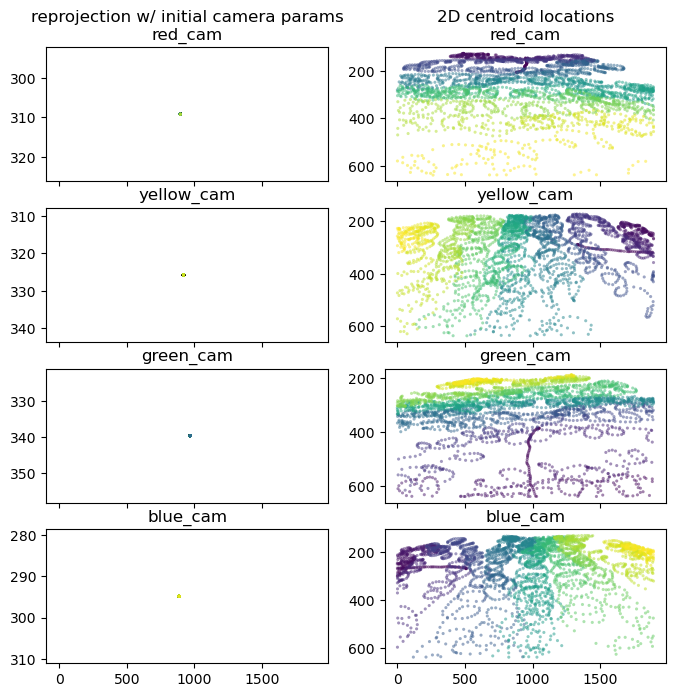

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6666e+09                                    1.76e+06    
       1              2         1.6666e+09      5.72e+04       1.01e-03       1.76e+06    
       2              3         1.6665e+09      1.14e+05       2.03e-03       1.76e+06    
       3              4         1.6662e+09      2.29e+05       4.06e-03       1.76e+06    
       4              5         1.6658e+09      4.58e+05       8.11e-03       1.76e+06    
       5              6         1.6649e+09      9.15e+05       1.62e-02       1.76e+06    
       6              7         1.6630e+09      1.83e+06       3.24e-02       1.76e+06    
       7              8         1.6594e+09      3.66e+06       6.49e-02       1.75e+06    
       8              9         1.6521e+09      7.30e+06       1.30e-01       1.75e+06    
       9             10         1.6375e+09      1.45e+07       2.59e-01       1.74e+06    

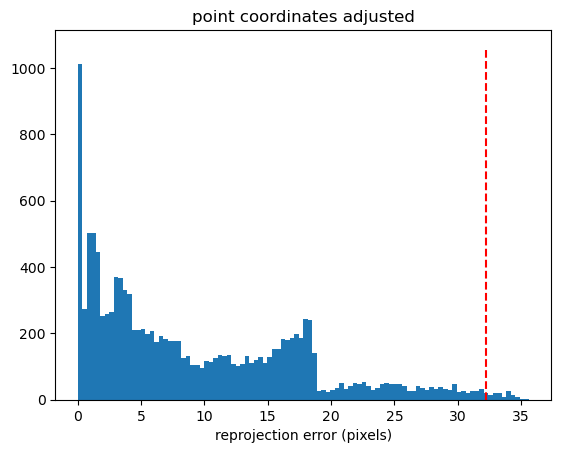

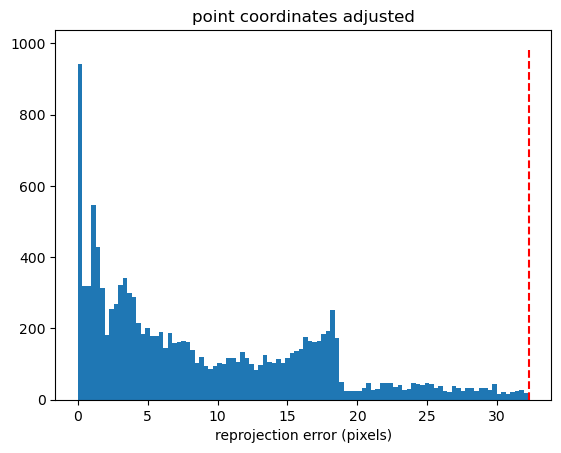


updated camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.05  |  -0.21  |   2.34  |  1852.83   |    -0.2   |    0.15   | 936.72 | 475.93 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.26  |  1852.83   |    -0.2   |    0.15   | 952.29 | 497.79 |
|  1.71 | -0.76 |  0.55 |   0.03  |   -0.2  |   2.32  |  1852.83   |    -0.2   |    0.15   | 942.32 | 499.13 |
|  1.77 |  0.74 | -0.54 |  -0.12  |  -0.26  |   2.3   |  1852.83   |    -0.2   |    0.15   | 981.09 | 501.48 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


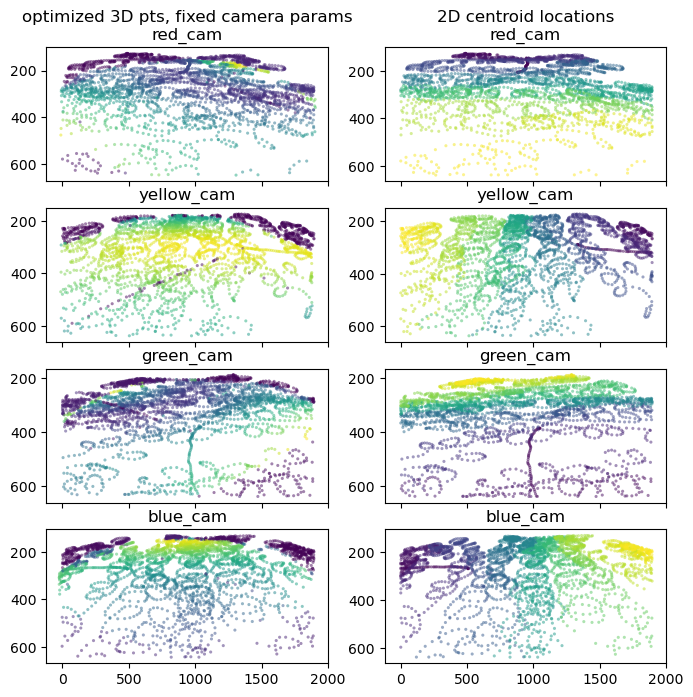

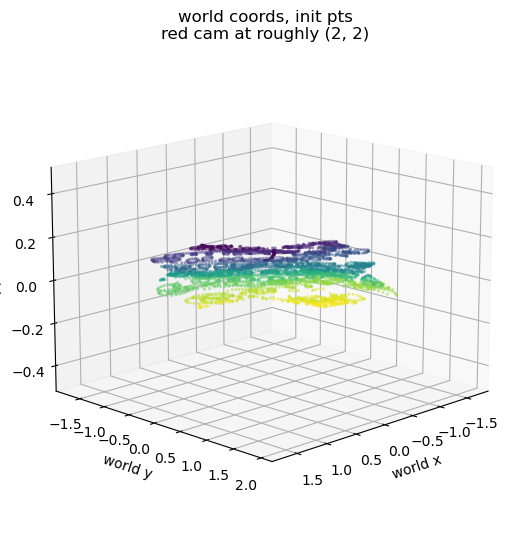

In [5]:
opt_cam_array, opt_3d_pts = calib.optimize_3d_coords(centroid_dir,
                                                     init_cam_array, cam_ids,
                                                     save_figs, save_files,
                                                     init_3D='zeros_init',
                                                     show_plots=True, save_plots=True)

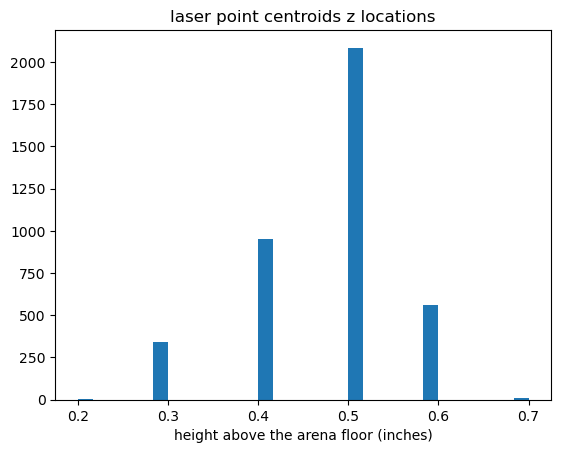

In [6]:
''' check the z heights of the 3D points (in inches)

this is a useful additional check if you know the approximate height of your laser points above the arena floor
'''
plt.hist(np.round(opt_3d_pts[:, -1]*13, 1), bins=30)
# plt.xlim([0, 5])
plt.title('laser point centroids z locations')
plt.xlabel('height above the arena floor (inches)')
plt.show()

In [7]:
# save the 3D point locations
opt_3d_pts_file = f"{save_files}opt_3d_points.npy"
np.save(opt_3d_pts_file, opt_3d_pts)

Step 2
-------
Given the updated 3d positions jointly optimize the camera parameters and 3D positions to minimize reconstruction errors.  

Optionally exclude points with high error and re-optimize the camera parameters and 3D positions.

This optimization will run for longer and should result in very low reprojection error (99th percentile around 0.7 pixels or less, bulk of the distribution near 0.1 - 0.2 pixels). This function will again output the reprojected point locations (colored by error - yellow is higher error) and the 3D point locations. 

In [8]:
opt_array_file = "opt_cam_array_pts_only.npy"
if os.path.isfile(f"{save_files}{opt_array_file}"):
    # load the camera array
    cam_array = np.load(f"{save_files}{opt_array_file}")
else:
    print('could not find array file, using initial estimate')
    cam_array = init_cam_array

input date of calibration video acquisition (YYMMDD): 240507
analyzing 3955 centroids

initial camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.05  |  -0.21  |   2.34  |  1852.83   |    -0.2   |    0.15   | 936.72 | 475.93 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.26  |  1852.83   |    -0.2   |    0.15   | 952.29 | 497.79 |
|  1.71 | -0.76 |  0.55 |   0.03  |   -0.2  |   2.32  |  1852.83   |    -0.2   |    0.15   | 942.32 | 499.13 |
|  1.77 |  0.74 | -0.54 |  -0.12  |  -0.26  |   2.3   |  1852.83   |    -0.2   |    0.15   | 981.09 | 501.48 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
   

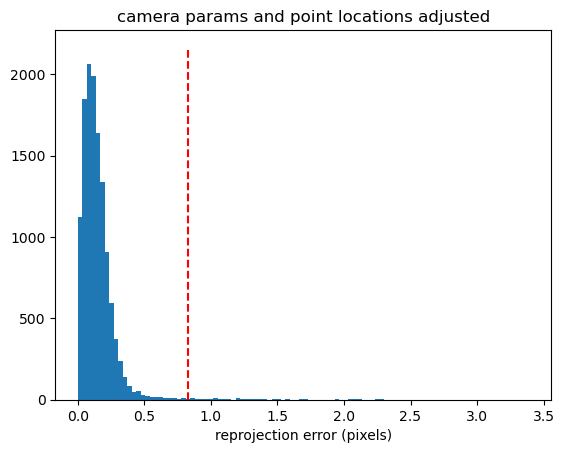

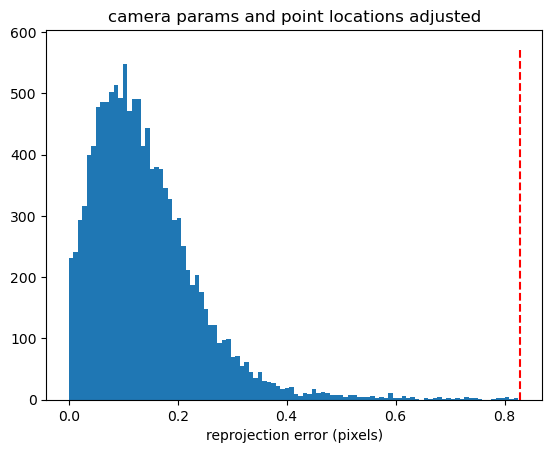


updated camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.06  |  -0.22  |   2.36  |  1852.89   |    -0.2   |    0.15   | 943.37 | 476.3  |
|  0.87 | -2.02 |  1.51 |  -0.01  |  -0.21  |   2.26  |  1852.89   |    -0.2   |    0.15   | 946.55 | 500.17 |
|  1.7  | -0.76 |  0.55 |   0.03  |  -0.19  |   2.3   |  1852.89   |    -0.2   |    0.15   | 949.85 | 497.44 |
|  1.77 |  0.75 | -0.55 |  -0.08  |  -0.26  |   2.31  |  1852.89   |    -0.2   |    0.15   | 973.86 | 502.78 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


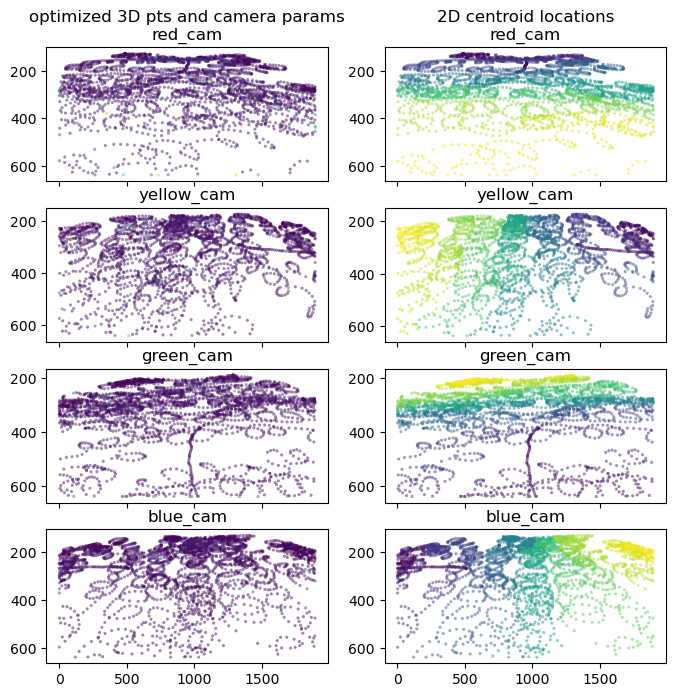

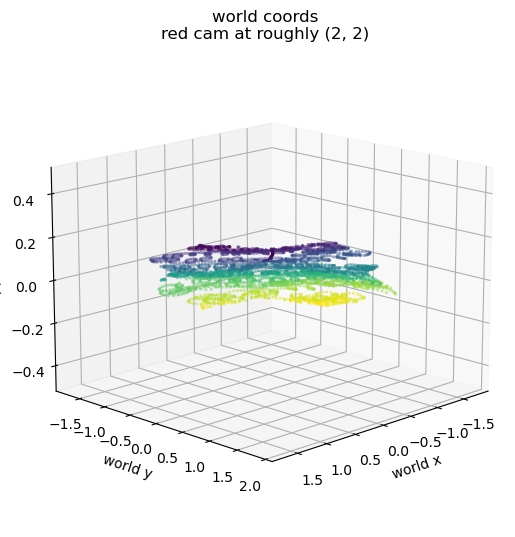

In [9]:
opt_cam_array, opt_3d_pts = calib.optimize_pts_cam(centroid_dir,
                                                   cam_array, cam_ids,
                                                   save_figs, save_files,
                                                   init_3D='optimized',
                                                   sharedcam=True, remove_high_error=False,
                                                   show_plots=True, save_plots=True
                                                  )

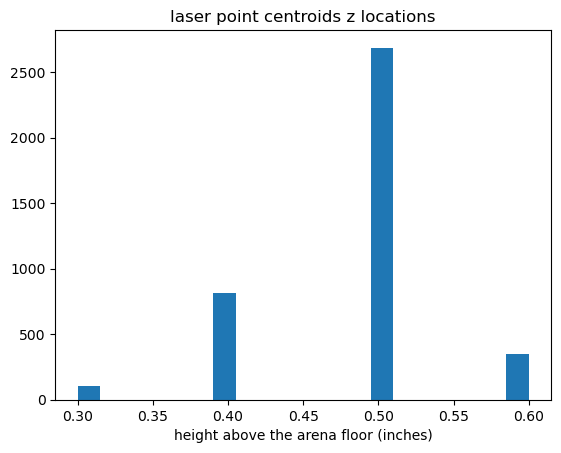

In [10]:
''' check the z heights of the 3D points (in inches) '''
plt.hist(np.round(opt_3d_pts[:, -1]*13, 1), bins=20)
# plt.xlim([0, 6])
plt.title('laser point centroids z locations')
plt.xlabel('height above the arena floor (inches)')
plt.show()

In [11]:
# save the 3D point locations
opt_3d_pts_file = f"{save_files}opt_3d_points.npy"
np.save(opt_3d_pts_file, opt_3d_pts)

In [12]:
# save the camera array for use in matlab for the Label3D GUI
calib.save_cam_array_matlab(opt_cam_array, save_files)

input today's date (YYMMDD): 240910


Step 3
---------
Now, use Label3D to select and triangulate known points using the optimized camera array from Step 2. If you haven't already, use init_world_coords_feeders.ipynb to establish the known point 3D locations.

Use these known points to apply a linear transform (rotation, translation, and scaling) to the camera extrinsics. This step reorients everything to the correct rotation/scaling.

Then, re-optimize the 3D point locations to check that the error is unchanged.

input date of known point image acquisition (YYMMDD): 240507


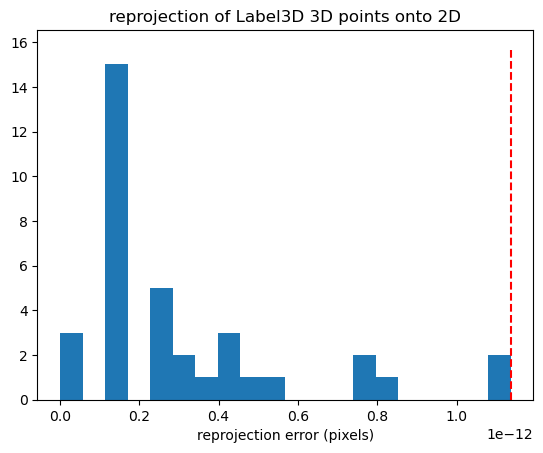

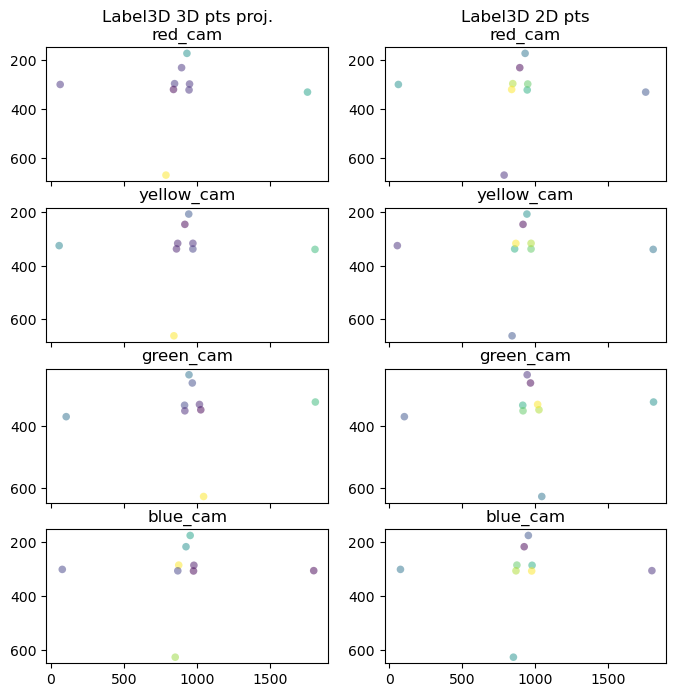

In [13]:
'''
Sanity check:
What is the reprojection error for the Label3D 3D point locations using the optimal array?
(should be zero if using the same array that the Label3D points were triangulated with)
'''
cam_array = np.load(f"{save_files}opt_cam_array_pts_cam.npy")
calib.sanity_check_label3D_pts(cam_array, cam_ids, known_pt_folder)

### Updating the extrinsics to normalize the coordinate system
Some linear algebra explaining how to update the camera extrinsics to map the known points onto the normalized arena coordinates.

**First, translate from the current known point locations ($W_{opt}$) to their normalized coordinates ($W_{targ}$)**

Mean center and normalize each matrix as follows:
$$ V_{ctr} = V - <V> $$
$$ s_V = \sqrt{\sum{(V_{ctr}^2)}}$$
$$ \bar{V} = \frac{V_{ctr}}{s_V} $$

Use procrustes to find the optimal rotation:
$$ min \quad ||\bar{W_{opt}} - Q\bar{W_{targ}}||_F$$
$$ s.t. \quad QQ^T = I$$
$$ \bar{W_{opt}} = Q\bar{W_{targ}} $$

Now, consider the translation and scaling terms.
$$ \frac{W_{opt} - <W_{opt}>}{s_{opt}} = Q\frac{W_{targ} - <W_{targ}>}{s_{targ}} $$
$$ \frac{1}{s_{opt}}(W_{opt} - <W_{opt}>) = \frac{1}{s_{targ}}Q(W_{targ} - <W_{targ}>) $$
$$ W_{opt} - <W_{opt}> = \frac{s_{opt}}{s_{targ}}Q(W_{targ} - <W_{targ}>) $$

Let $\frac{s_{opt}}{s_{targ}} = s$ be the "scaling factor".
$$ W_{opt} = sQ(W_{targ} - <W_{targ}>) + <W_{opt}> $$
$$ W_{opt} = sQW_{targ} - sQ<W_{targ}> + <W_{opt}> $$
$$ W_{opt} = s[QW_{targ} + (\frac{1}{s}<W_{opt}> - Q<W_{targ}>)] $$

We now have:
- a scaling factor $s$
- a rotation matrix $Q$
- and a translation vector $P = \frac{1}{s}<W_{opt}> - Q<W_{targ}>$

Such that $W_{opt} = s(QW_{targ} + P)$

**Update the extrinsics to output the correctly normalized arena coordinates**

The current extrinsics define a rotation and translation that converts the arbitrary optimized points $W_{opt}$ into camera coordinates $C$:
$$ C = R_{opt}W_{opt} + T_{opt} $$

We can plug in for $W_{opt}$ using the rotation, translation, and scaling calculated above:
$$ W_{opt} = s(QW_{targ} + P) $$
$$ C = R_{opt}(s(QW_{targ} + P)) + T_{opt} $$
$$ C = sR_{opt}QW_{targ} + sR_{opt}P + T_{opt} $$
$$ C = s(R_{opt}QW_{targ} + R_{opt}P + \frac{1}{s}T_{opt}) $$

We now have:
- a scaling factor $s$
- a rotation matrix $R_{new} = R_{opt}Q$
- a translation vector $T_{new} = R_{opt}P + \frac{1}{s}T_{opt}$

For some reason, plugging these new rotation and translation vectors into the camera extrinsics (without accounting for the scaling term) results in the correctly scaled output points. Still not totally sure why this works...

In [14]:
def transform(A, B):
    '''
    Given matrices A and B of equal shape, computes the:
    - orthogonal rotation matrix Q
    - translation matrix P
    - scaling factor s
    to map B onto A:
    
    A = RB + T
    '''    
    # mean center the matrices
    A_mean = np.mean(A, axis=0)
    B_mean = np.mean(B, axis=0)
    A_ctr = A - A_mean
    B_ctr = B - B_mean
    
    # re-scale to normalize
    A_scale = np.sqrt(np.sum(A_ctr**2))
    B_scale = np.sqrt(np.sum(B_ctr**2))
    scale = A_scale/B_scale
    print(f'scaling factor = {scale}')
    
    # get the rotation matrix using Procrustes
    rot = orthogonal_procrustes(A_ctr, B_ctr)[0]

    # compute the translation vector
    trans = (1/scale) * A_mean -  rot @ B_mean 
    
    # re-scale rotation and translation
    
    return rot, trans, scale

In [15]:
def vec_to_mat(v):
    '''
    convert a rotation vector into a rotation matrix
    '''
    r = Rotation.from_rotvec(v)
    return r.as_matrix()

def mat_to_vec(v):
    '''
    convert a rotation vector into a rotation matrix
    '''
    r = Rotation.from_matrix(v)
    return r.as_rotvec()

In [16]:
def transform_extrinsics(known_pt_folder, cam_array):
    ''' Map the optimized 3D known point locations onto their normalized arena coordinates '''
    # 3D coordinates given the current camera array
    img_date = input("input date of known point image acquisition (YYMMDD): ")
    pts_3d_opt = np.load(f'{known_pt_folder}{img_date}_points_3d.npy') # 3 x n_known_points

    # normalized 3D coordinates
    pts_3d_targ = np.load(f'{known_pt_folder}points_3d_simple.npy') # 3 x n_known_points
    
    # find a rotation and translation from pts_3d_opt to pts_3d_targ
    rot_pts, trans_pts, scale_pts = transform(pts_3d_opt, pts_3d_targ)
    
    ''' Update the extrinsics for each camera by applying the rotation and translation '''
    n_cams = cam_array.shape[0]
    adj_cam_arry = cam_array.copy()
    for c in range(n_cams):
        rot_vec = cam_array[c, :3]
        rot_cam = vec_to_mat(rot_vec)
        trans_cam = cam_array[c, 3:6]

        rot_adj = rot_cam @ rot_pts
        rot_vec_adj = mat_to_vec(rot_adj)
        trans_adj = rot_cam @ trans_pts + (1/scale_pts) * trans_cam

        adj_cam_arry[c, :3] = rot_vec_adj
        adj_cam_arry[c, 3:6] = trans_adj
        
    return adj_cam_arry

In [17]:
''' Update the camera extrinsics to map the current known points onto their normalized coordinates'''
cam_array = np.load(f"{save_files}opt_cam_array_pts_cam.npy")
adj_cam_arry = transform_extrinsics(known_pt_folder, cam_array)

input date of known point image acquisition (YYMMDD): 240507
scaling factor = 0.9997289105299462


input date of calibration video acquisition (YYMMDD): 240507
analyzing 3955 centroids

initial camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.06  |  -0.21  |   2.34  |  1852.89   |    -0.2   |    0.15   | 943.37 | 476.3  |
|  0.87 | -2.02 |  1.51 |  -0.03  |  -0.21  |   2.26  |  1852.89   |    -0.2   |    0.15   | 946.55 | 500.17 |
|  1.71 | -0.76 |  0.55 |   0.03  |   -0.2  |   2.32  |  1852.89   |    -0.2   |    0.15   | 949.85 | 497.44 |
|  1.77 |  0.75 | -0.55 |  -0.06  |  -0.26  |   2.31  |  1852.89   |    -0.2   |    0.15   | 973.86 | 502.78 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


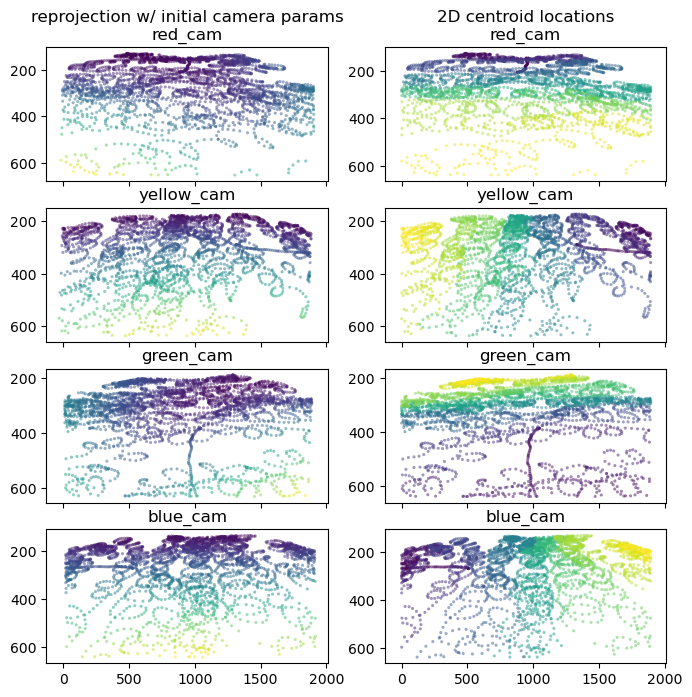

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2130e+06                                    6.99e+04    
       1              2         3.4599e+02      1.21e+06       1.44e+00       6.44e+02    
       2              3         3.2676e+02      1.92e+01       5.48e-03       2.88e-01    
       3              4         3.2676e+02      7.69e-07       1.51e-06       2.94e-02    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.2130e+06, final cost 3.2676e+02, first-order optimality 2.94e-02.


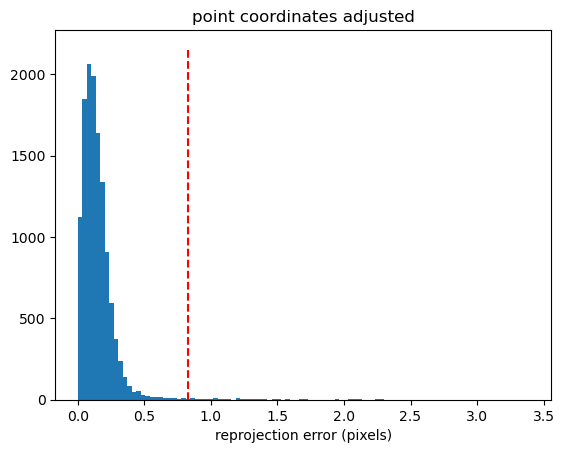

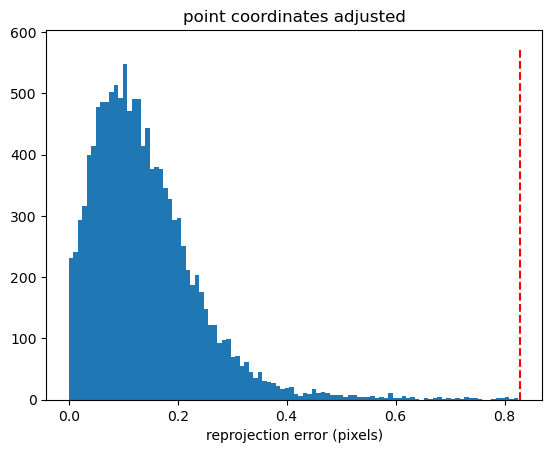


updated camera params
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.06  |  -0.21  |   2.34  |  1852.89   |    -0.2   |    0.15   | 943.37 | 476.3  |
|  0.87 | -2.02 |  1.51 |  -0.03  |  -0.21  |   2.26  |  1852.89   |    -0.2   |    0.15   | 946.55 | 500.17 |
|  1.71 | -0.76 |  0.55 |   0.03  |   -0.2  |   2.32  |  1852.89   |    -0.2   |    0.15   | 949.85 | 497.44 |
|  1.77 |  0.75 | -0.55 |  -0.06  |  -0.26  |   2.31  |  1852.89   |    -0.2   |    0.15   | 973.86 | 502.78 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


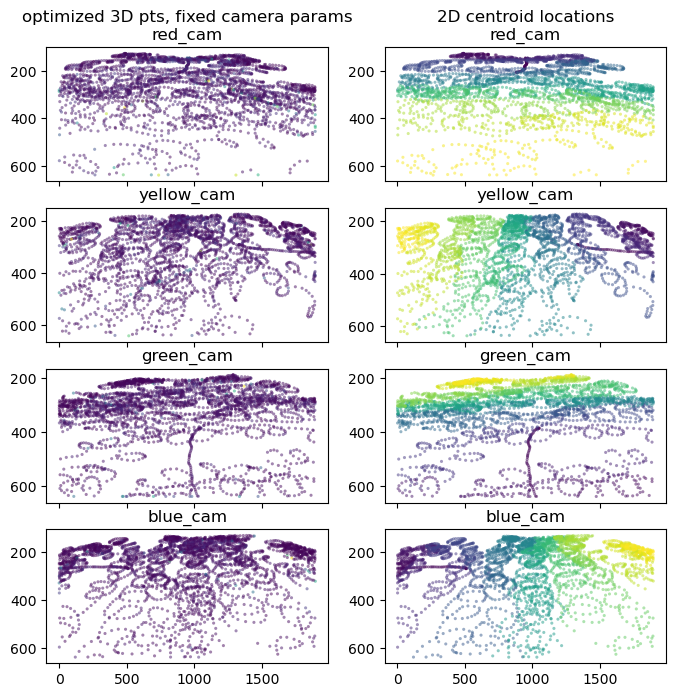

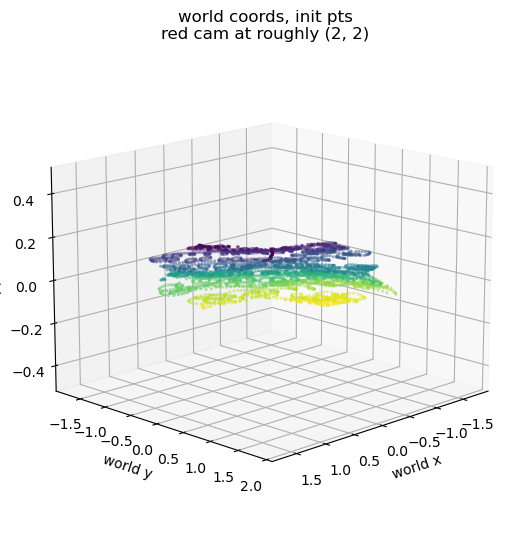

In [18]:
''' Update the 3D point locations for the new extrinsics '''
opt_cam_array, adj_3d_pts = calib.optimize_3d_coords(centroid_dir,
                                                     adj_cam_arry, cam_ids,
                                                     save_figs, save_files,
                                                     init_3D='optimized',
                                                     show_plots=True, save_plots=True)

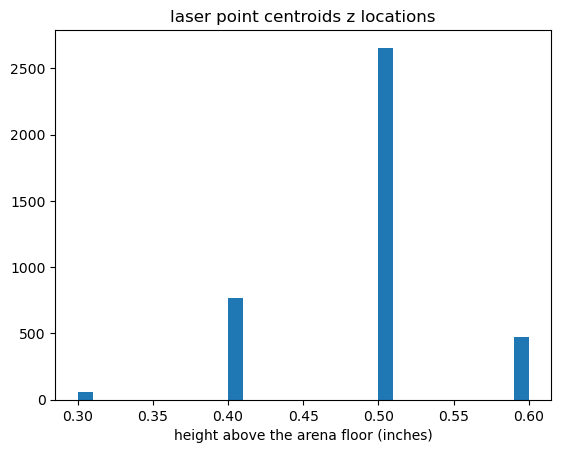

In [19]:
''' check the z heights of the 3D points (in inches) '''
plt.hist(np.round(adj_3d_pts[:, -1]*13, 1), bins=30)
# plt.xlim([0, 6])
plt.title('laser point centroids z locations')
plt.xlabel('height above the arena floor (inches)')
plt.show()

In [20]:
# save for use in matlab, if desired
calib.save_cam_array_matlab(opt_cam_array, save_files)

input today's date (YYMMDD): 240910
